In [346]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

# np.random.seed(114514)
# xp.random.seed(114514)

In [ ]:



import copy 

class Fstatistics(Likelihood):
    extrinsic_parameter_names = [
        "luminosity_distance", 
        "inclination", 
        "coalescence_phase", 
        "psi"
        ]
    intrinsic_parameter_names = [
        'chirp_mass',
        'mass_ratio',
        'spin_1z',
        'spin_2z',
        'coalescence_time',
        'longitude',
        'latitude'
        ]
    def __init__(self, response_generator, frequency, data, invserse_covariance_matrix, response_parameters, use_gpu=False):
        super().__init__(response_generator, frequency, data, invserse_covariance_matrix, response_parameters, use_gpu)
        self.SUM = self.xp.sum 
        self.CONJ = self.xp.conjugate
        self.RE = self.xp.real
        self.NX = self.xp.newaxis 
        self.MATMUL = self.xp.matmul
        self.TRANS = self.xp.transpose

    def self_inner_product_vectorized(self, template_channels):
        """ 
            template_channels: shape (Nevent, Nchannel, Nfreq)
        """
        residual = self.TRANS(template_channels, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger = self.CONJ(residual[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)
        residual = residual[:, :, :, self.NX] # (Nevent, Nf, 3, 1)
        inners = self.SUM(self.MATMUL(self.MATMUL(residual_dagger, self.invserse_covariance_matrix), residual), axis=(1,2,3)) # (Nevent)
        return self.RE(inners) # (Nevent)
    
    def inner_product_vectorized(self, template_channels1, template_channels2):
        """ 
            template_channels1: shape (Nevent, Nchannel, Nfreq)
            template_channels2: shape (Nevent, Nchannel, Nfreq)
        """
        residual1 = self.TRANS(template_channels1, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger1 = self.CONJ(residual1[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)

        residual2 = self.TRANS(template_channels2, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual2 = residual2[:, :, :, self.NX] # (Nevent, Nf, 3, 1)

        inners = self.SUM(self.MATMUL(self.MATMUL(residual_dagger1, self.invserse_covariance_matrix), residual2), axis=(1,2,3)) # (Nevent)
        return self.RE(inners) # (Nevent)

    def calculate_Fstat_vectorized(self, intrinsic_parameters, return_a=False, return_recovered_wave=False):
        """  
        calculate F-statistics for a batch of events TODO: expand to HM waveform 
        Args: 
            intrinsic_parameters: dictionary of intrinsic parameters (except for D, iota, phic, psi), each item is a numpy array of shape (Nevent). 
        Returns: 
            F-statistics of events 
        """
        Nevent = len(np.atleast_1d(intrinsic_parameters["chirp_mass"]))
        
        full_parameters1 = copy.deepcopy(intrinsic_parameters)
        full_parameters1["luminosity_distance"] = np.ones(Nevent) * 0.25 
        full_parameters1["coalescence_phase"] = np.zeros(Nevent)
        full_parameters1["inclination"] = np.ones(Nevent) * PI / 2. 
        full_parameters1["psi"] = np.zeros(Nevent)
        # print("1st parameter set:") # TEST 
        # print(full_parameters1) # TEST 

        temp1 = self.response_generator.Response(
            parameters=full_parameters1,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)
        
        full_parameters2 = copy.deepcopy(full_parameters1)
        full_parameters2["psi"] = np.ones(Nevent) * PI / 4. 
        # print("2nd parameter set:") # TEST 
        # print(full_parameters2) # TEST 

        temp2 = self.response_generator.Response(
            parameters=full_parameters2,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)

        if Nevent == 1:
            temp1 = temp1[:, self.NX, :]
            temp2 = temp2[:, self.NX, :]

        X1 = self.TRANS(temp1, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X2 = 1.j * X1 # (Nevent, Nchannel, Nfreq)
        X3 = self.TRANS(temp2, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X4 = 1.j * X3 # (Nevent, Nchannel, Nfreq) 
        # print("shape of X1:", X1.shape) # TEST 
        
        data_expand = self.data[self.NX, :, :] # (1, Nchannel, Nfreq)
        Nvector = self.TRANS(self.xp.array([
            self.inner_product_vectorized(data_expand, X1), 
            self.inner_product_vectorized(data_expand, X2), 
            self.inner_product_vectorized(data_expand, X3), 
            self.inner_product_vectorized(data_expand, X4), 
        ])) # (4, Nevent) -> (Nevent, 4) inner products, all real numbers 
        # print("shape of N vector:", Nvector.shape) # TEST 
        
        M12 = self.inner_product_vectorized(X1, X2) # (Nevent), real numbers 
        M13 = self.inner_product_vectorized(X1, X3)
        M14 = self.inner_product_vectorized(X1, X4)
        M23 = self.inner_product_vectorized(X2, X3)
        M24 = self.inner_product_vectorized(X2, X4)
        M34 = self.inner_product_vectorized(X3, X4)
        Mmatrix = self.TRANS(self.xp.array([
            [self.self_inner_product_vectorized(X1), M12, M13, M14], 
            [M12, self.self_inner_product_vectorized(X2), M23, M24], 
            [M13, M23, self.self_inner_product_vectorized(X3), M34], 
            [M14, M24, M34, self.self_inner_product_vectorized(X4)]
        ]), axes=(2, 0, 1)) # (4, 4, Nevent) -> (Nevent, 4, 4) inner products, all real numbers 
        # print("shape of M matrix:", Mmatrix.shape) # TEST 
        
        invMmatrix = self.xp.linalg.inv(Mmatrix) # (Nevent, 4, 4)
        
        Nvector_col = Nvector[..., self.NX] # (Nevent, 4, 1)
        NM = self.MATMUL(invMmatrix, Nvector_col) # (Nevent, 4, 1)
        Nvector_row = Nvector[:, self.NX, :] # (Nevent, 1, 4)
        NMN = self.MATMUL(Nvector_row, NM) # (Nevent, 1, 1)
        
        res = 0.5 * NMN[:, 0, 0] # (Nevent) Fstat 0.5 * N^T M^{-1} N
        
        if return_a:
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            if self.use_gpu:
                return res_a.get() # (Nevent, 4)
            else: 
                return res_a # (Nevent, 4)
            
        if return_recovered_wave: 
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            res_wf = res_a[:, 0] * self.TRANS(X1, axes=(1, 2, 0)) # (Nchannel, Nfreq, Nevent)
            res_wf += res_a[:, 1] * self.TRANS(X2, axes=(1, 2, 0))
            res_wf += res_a[:, 2] * self.TRANS(X3, axes=(1, 2, 0))
            res_wf += res_a[:, 3] * self.TRANS(X4, axes=(1, 2, 0)) 
            return self.TRANS(res_wf, (0, 2, 1)) # (Nchannel, Nevent, Nfreq)

        # else:
        if self.use_gpu:
            return res.get() # (Nevent)
        else: 
            return res 
        
    @staticmethod
    def a_to_extrinsic_vectorized(a):
        """ 
        TODO: expand to HM waveform 
        Args: 
            a: (Nevent, 4), numpy array of the a coefficients 
        Returns: 
            dictionary of extrinsic parameters 
        """
        extrinsic_parameters = dict()
        
        P = np.linalg.norm(a, axis=1) ** 2 # (Nevent)
        Q = a[:, 1] * a[:, 2] - a[:, 0] * a[:, 3] # (Nevent)
        Delta = np.sqrt(P ** 2 - 4. * Q ** 2) # (Nevent)
        Aplus = np.sqrt((P + Delta) / 2.) # (Nevent)
        Across = np.sign(Q) * np.sqrt((P - Delta) / 2.) # (Nevent)
        
        tmp = Aplus + np.sqrt(Aplus ** 2 - Across ** 2) # (Nevent)
        extrinsic_parameters["luminosity_distance"] = 0.5 / tmp # (Nevent)
        extrinsic_parameters["inclination"] = np.arccos(Across / tmp) # (Nevent)
        # extrinsic_parameters["coalescence_phase"] = -np.arctan(2. * (a[:, 0] * a[:, 1] + a[:, 2] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 2] ** 2 - a[:, 1] ** 2 - a[:, 3] ** 2)) / 2. # (Nevent), one possible solution 
        # extrinsic_parameters["psi"] = np.arctan(2. * (a[:, 0] * a[:, 2] + a[:, 1] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 1] ** 2 - a[:, 2] ** 2 - a[:, 3] ** 2)) / 4. # (Nevent), one possible solution 

        P = np.sqrt((a[:, 0] + a[:, 3])**2 + (a[:, 1] - a[:, 2])**2)
        Q = np.sqrt((a[:, 0] - a[:, 3])**2 + (a[:, 1] + a[:, 2])**2)
        Aplus = P + Q 
        Across = P - Q 
        A = Aplus + np.sqrt(Aplus**2 + Across**2)
        extrinsic_parameters["psi"] = 0.5 * np.arctan((Aplus*a[:, 3] - Across*a[:, 0]) / (Aplus*a[:, 1] + Across*a[:, 2]))
        extrinsic_parameters["coalescence_phase"] = np.arctan((Aplus*a[:, 3] - Across*a[:, 0]) / (Aplus*a[:, 2] + Across*a[:, 1])) / (-2.)
        extrinsic_parameters["psi"][extrinsic_parameters["psi"]<0.] += PI 
        extrinsic_parameters["coalescence_phase"][extrinsic_parameters["coalescence_phase"]<0.] += 2.*PI 
        # extrinsic_parameters["inclination"] = np.arccos(-Across/A)
        
        if a.shape[0] == 1:
            extrinsic_parameters_out = dict() 
            for k, v in extrinsic_parameters.items():
                extrinsic_parameters_out[k] = v[0]
            return extrinsic_parameters_out
        else:              
            return extrinsic_parameters
    
    @staticmethod
    def IntParamDict2ParamArr(param_dict):
        return np.array([
            np.log10(param_dict['chirp_mass']),
            param_dict['mass_ratio'],
            param_dict['spin_1z'],
            param_dict['spin_2z'],
            param_dict['coalescence_time'],
            param_dict['longitude'],
            np.sin(param_dict['latitude']),
        ]) # (Nparams, Nevent)

    @staticmethod
    def IntParamArr2ParamDict(params):
        p = dict()
        p['chirp_mass'] = np.power(10., params[0])
        p['mass_ratio'] = params[1]
        p['spin_1z'] = params[2]
        p['spin_2z'] = params[3]
        p['coalescence_time'] = params[4]
        p['longitude'] = params[5]
        p['latitude'] = np.arcsin(params[6])
        return p 

## Data settings 

In [348]:
t_start = 10. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies.shape 

(21601,)

In [349]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies, dtype=bool)
for i in range(1, 40): 
    mask_idx = np.where(np.abs(data_frequencies - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 
data_frequencies = data_frequencies[mask]

# remove the frequencies below Taiji sensitive band 
mask = np.where(data_frequencies > 1e-5)[0]
data_frequencies = data_frequencies[mask]
data_frequencies_GPU = xp.array(data_frequencies)

data_frequencies.shape 

(21077,)

## Set response model 

In [350]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
)

## Source parameter priors 

In [351]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [t_start/DAY+3., t_end/DAY] # ensure at least 3-day data before merger 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.5       ,  6.5       ],
       [ 0.1       ,  1.        ],
       [-0.9       ,  0.9       ],
       [-0.9       ,  0.9       ],
       [13.        , 15.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ]])

## Noise model 

In [352]:
arm_time = (t_start + t_end) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

((3, 21077), (21077, 3, 3))

## Data simulation 

In [353]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
data_channels = wf_channels + noise_channels 

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 2836264.3413750925
mass_ratio : 0.41713116358651625
spin_1z : -0.7230195583257855
spin_2z : -0.5298846971704037
coalescence_time : 13.77126385947927
coalescence_phase : 0.7865408431413943
luminosity_distance : 10014.708213803651
inclination : 0.8287451445538048
longitude : 2.7719018323085414
latitude : 1.095547010526662
psi : 0.12063716340023403
optimal SNR: 3157.049236559058


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

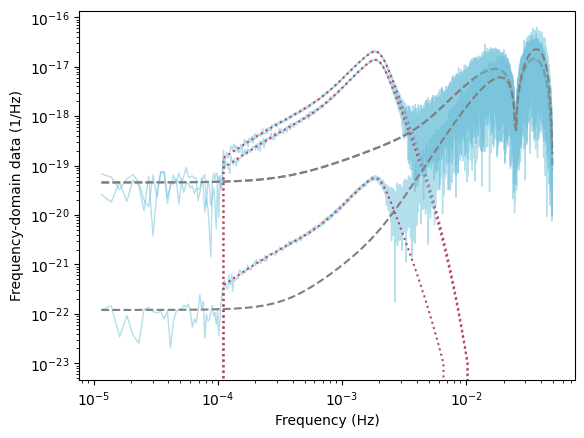

In [354]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## MLE with  $\mathcal{F}$-stat 

In [355]:
Fstat = Fstatistics(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True
)

number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


### test waveform and parameter recovery

In [356]:
int_params = dict()
for key in Fstatistics.intrinsic_parameter_names:
    int_params[key] = mbhb_parameters[key]
int_params

{'chirp_mass': 2836264.3413750925,
 'mass_ratio': 0.41713116358651625,
 'spin_1z': -0.7230195583257855,
 'spin_2z': -0.5298846971704037,
 'coalescence_time': 13.77126385947927,
 'longitude': 2.7719018323085414,
 'latitude': 1.095547010526662}

In [357]:
rec_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_a=True, 
)

rec_ext_params = Fstat.a_to_extrinsic_vectorized(rec_a)

rec_params = dict(int_params, **rec_ext_params)

print("parameter name | difference")
for k, v in rec_ext_params.items():
    print(k, ":", v-mbhb_parameters[k])

parameter name | difference
luminosity_distance : 2.7722683032716304
inclination : -0.00036105210703707424
psi : -0.0008405374803404919
coalescence_phase : 4.711615767275627


In [142]:
rec_wave = FDTDI_GPU.Response(
    rec_params, 
    data_frequencies_GPU, 
    **response_kwargs_GPU
)

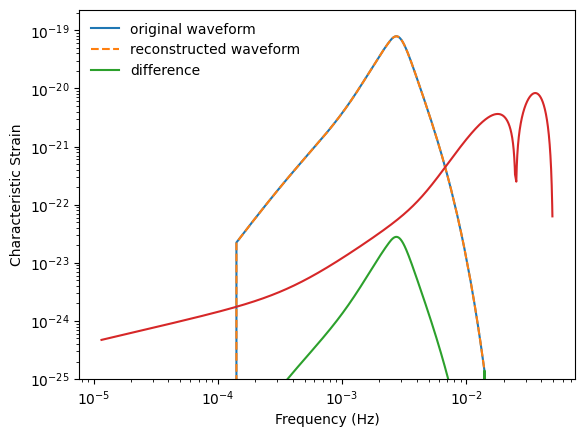

In [14]:
plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0].get()) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0].get() - wf_channels[0].get()) * data_frequencies, label="difference")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

### optimization from prior 

In [ ]:
from scipy.optimize import differential_evolution

# n_dim_int = len(Fstatistics.intrinsic_parameter_names)
# print("number of parameters to be optimized:", n_dim_int)

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
    """
    int_params = norm_int_params.transpose() * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nevent, Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
    return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_results = [] 
DE_fun = [] 
DE_res_snr = [] 
for _ in range(3):
    tmp = differential_evolution(
        func=cost_function,
        bounds=bounds,
        x0=None,
        strategy='best1exp',
        # strategy='rand1bin',
        maxiter=5000,
        popsize=10*n_dim_int,
        # popsize=6*n_dim_int, 
        tol=1e-7,
        atol=1e-9,
        # tol=1e-6,
        # atol=1e-8,
        mutation=(0.4, 0.95),
        recombination=0.7,
        disp=False,
        polish=False,
        vectorized=True,
    )
    DE_results.append(tmp)
    DE_fun.append(tmp.fun)

    searched_int_params = Fstat.IntParamArr2ParamDict(tmp.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])
    searched_a = Fstat.calculate_Fstat_vectorized(
        intrinsic_parameters=searched_int_params, 
        return_a=True, 
    ) # (1, 4)
    searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)
    searched_params = dict(searched_int_params, **searched_ext_params)
    searched_wf = FDTDI_GPU.Response(
        searched_params, 
        data_frequencies_GPU, 
        **response_kwargs_GPU
    )
    searched_residual = (searched_wf - data_channels).get()
    DE_res_snr.append(np.abs(FrequencyDomainCovarianceSNR(data_channels=searched_residual, inv_cov=InvCovMat)))

DE_result = DE_results[np.argmin(np.array(DE_res_snr))]
print(DE_result)

/home/ps/miniconda3/envs/tdc/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


             message: Optimization terminated successfully.
             success: True
                 fun: -9459328.549271673
                   x: [ 8.008e-01  3.043e-01  3.077e-01  7.939e-02
                        4.470e-01  8.033e-01  7.824e-01]
                 nit: 485
                nfev: 486
          population: [[ 8.008e-01  3.043e-01 ...  8.033e-01  7.824e-01]
                       [ 8.007e-01  3.046e-01 ...  8.033e-01  7.807e-01]
                       ...
                       [ 8.007e-01  3.042e-01 ...  8.041e-01  7.818e-01]
                       [ 8.007e-01  3.045e-01 ...  8.017e-01  7.784e-01]]
 population_energies: [-9.459e+06 -9.459e+06 ... -9.459e+06 -9.459e+06]


In [16]:
DE_res_snr

[289.6870991612524, 8703.938153422769, 289.6873620394268]

### reconstruct parameters and waveforms 

In [17]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

searched_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

print("parameter name | difference")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]))

parameter name | difference
chirp_mass 519.1410309490748
mass_ratio 0.0005571251412820333
spin_1z 0.0018896642446374345
spin_2z 0.007136617267270218
coalescence_time 3.054010489655923e-05
longitude 0.047578768920673475
latitude 0.026291570781657225
luminosity_distance 791.5778458204877
inclination 0.05867528094706076
psi 1.4623626922295134
coalescence_phase 4.579753135076081


(1e-25, 1.8640769813296584e-19)

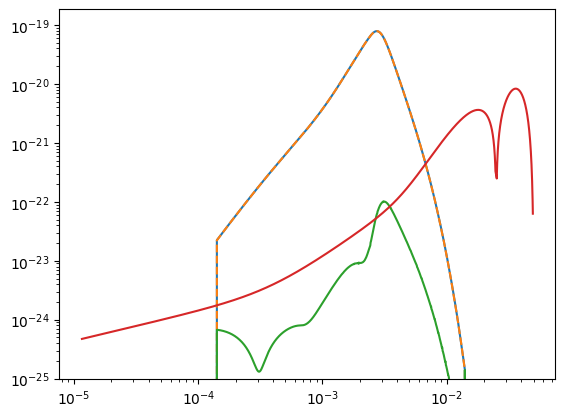

In [18]:
# searched_wf = Fstat.calculate_Fstat_vectorized(
#     intrinsic_parameters=searched_int_params, 
#     return_recovered_wave=True
# )[:, 0, :]

searched_wf = FDTDI_GPU.Response(
    searched_params, 
    data_frequencies_GPU, 
    **response_kwargs_GPU
)

plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies)
plt.loglog(data_frequencies, np.abs(searched_wf[0].get()) * data_frequencies, linestyle="--")
plt.loglog(data_frequencies, np.abs(searched_wf[0].get() - wf_channels[0].get()) * data_frequencies, linestyle="-")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))
plt.ylim(1e-25, )

## Fisher analysis 

In [19]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.01,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    # param_dict=mbhb_parameters, 
    param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=0,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

{'chirp_mass': 436.4282644926511,
 'mass_ratio': 0.0008559166882463723,
 'spin_1z': 0.00803174332503124,
 'spin_2z': 0.023842814247957977,
 'coalescence_time': 6.412965633078326e-05,
 'coalescence_phase': 0.07174946153178816,
 'luminosity_distance': 646.3087491015948,
 'inclination': 0.041509991916983284,
 'longitude': 0.04644440664392051,
 'latitude': 0.02491919954263717,
 'psi': 0.05329627891166495}

In [20]:
print("parameter name | difference | FIM bound | ratio")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]), FIM.param_errors[k], np.abs(v-mbhb_parameters[k]) / FIM.param_errors[k])

parameter name | difference | FIM bound | ratio
chirp_mass 519.1410309490748 436.4282644926511 1.1895220204231671
mass_ratio 0.0005571251412820333 0.0008559166882463723 0.6509104787096603
spin_1z 0.0018896642446374345 0.00803174332503124 0.23527448128829295
spin_2z 0.007136617267270218 0.023842814247957977 0.29931941729074346
coalescence_time 3.054010489655923e-05 6.412965633078326e-05 0.4762243655108985
longitude 0.047578768920673475 0.04644440664392051 1.0244240880381976
latitude 0.026291570781657225 0.02491919954263717 1.0550728460066265
luminosity_distance 791.5778458204877 646.3087491015948 1.2247673374696304
inclination 0.05867528094706076 0.041509991916983284 1.4135218591322953
psi 1.4623626922295134 0.05329627891166495 27.43836384249795
coalescence_phase 4.579753135076081 0.07174946153178816 63.829791015881696


In [21]:
mbhb_parameters

{'chirp_mass': 1999247.0955513788,
 'mass_ratio': 0.37445801498523956,
 'spin_1z': -0.3479972239387985,
 'spin_2z': -0.7499538363434327,
 'coalescence_time': 13.894078599040203,
 'coalescence_phase': 5.331126602001535,
 'luminosity_distance': 26894.03919163371,
 'inclination': 2.78365658857929,
 'longitude': 4.999543958059895,
 'latitude': 0.6263958286981298,
 'psi': 1.375529001500487}